In [1]:
from lightfm.data import Dataset
import pandas as pd

from src.config import DATA_PATH, DATASET_PATH

In [2]:
ratings_df = pd.read_csv(
    DATASET_PATH / "u.data",
    sep="\t",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
)

In [3]:
users_df = pd.read_csv(DATA_PATH / "interim" / "users_with_coordinates.csv")

In [ ]:
movielens_dataset = Dataset()

In [ ]:
movielens_dataset.fit(
    users=users_df.user_id,
    items=ratings_df.item_id,
    user_features=users_df.drop(columns=["user_id"]),
)

In [213]:
def make_recommendation(model, user_id, items, k=20) -> set[int]:
    scores = model.predict(
        user_id - 1, items, user_features=user_features, item_features=movie_features
    )

    top_items = np.argsort(-scores)
    return set(top_items[:k])

In [262]:
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from src.utils import set_seed
from tqdm.notebook import tqdm

set_seed(42)
K = 20

# Load Movielens-100k training dataset
train_data = pd.read_csv(
    DATASET_PATH / "ua.base",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
)

# Load Movielens-100k test dataset
test_data = pd.read_csv(
    DATASET_PATH / "ua.test",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
)


# Load user features from users_with_coordinates.csv
user_data = pd.read_csv(DATA_PATH / "interim" / "users_with_coordinates.csv")
# Define age bins and labels
bins = [0, 18, 35, 50, 100]  # Define your desired age groups
labels = ["0-18", "19-35", "36-50", "51-100"]  # Labels for the age groups

# Add a new column 'age_group' to your DataFrame
user_data["age_group"] = pd.cut(user_data["age"], bins=bins, labels=labels, right=False)

# Load movies features from u.item file
genres = pd.read_csv(
    DATASET_PATH / "u.genre",
    sep="|",
    encoding="ISO-8859-1",
    header=None,
    names=["genre", "genre_id"],
).reset_index()

genres = genres.genre.tolist()

movie_data = pd.read_csv(
    DATASET_PATH / "u.item",
    sep="|",
    encoding="ISO-8859-1",
    header=None,
    names=["item_id", "title", "release_date", "video_release_date", "imdb_url"]
    + genres,
)

movie_data_with_genres = movie_data.drop(columns=genres)
movie_data_with_genres["genre"] = movie_data[genres].idxmax(1)


# Preprocess the data
dataset = Dataset()
dataset.fit(
    user_data.user_id,
    movie_data.item_id,
    user_features=[
        *user_data.age_group.unique(),
        *user_data.gender.unique(),
        *user_data.occupation.unique(),
    ],
    item_features=[
        *movie_data_with_genres.genre.unique(),
    ],
)

# Build interactions matrices for training and test sets
(train_interactions, train_weights) = dataset.build_interactions(
    (train_data["user_id"][i], train_data["item_id"][i]) for i in range(len(train_data))
)
(test_interactions, test_weights) = dataset.build_interactions(
    (test_data["user_id"][i], test_data["item_id"][i]) for i in range(len(test_data))
)

# Build user features matrix
user_features = dataset.build_user_features(
    (
        user_data["user_id"][i],
        [user_data["age_group"][i], user_data["gender"][i], user_data["occupation"][i]],
    )
    for i in range(len(user_data))
)

# Build movie features matrix
movie_features = dataset.build_item_features(
    (movie_data_with_genres["item_id"][i], [movie_data_with_genres["genre"][i]])
    for i in range(len(movie_data_with_genres))
)
# movie_features = None

# Build the recommendation model
model = LightFM(loss="warp", random_state=42, no_components=256)

epochs = 30

epochs_range = np.arange(1, epochs + 1)
train_precision_list, train_recall_list, train_auc_list, train_f1_list = [], [], [], []
test_precision_list, test_recall_list, test_auc_list, test_f1_list = [], [], [], []

for epoch in (pbar := tqdm(range(epochs))):
    # Train the model for one epoch
    model.fit_partial(
        train_interactions,
        user_features=user_features,
        epochs=1,
        item_features=movie_features,
    )

    # Evaluate the model on the training set
    train_precision = precision_at_k(
        model,
        train_interactions,
        user_features=user_features,
        k=K,
        item_features=movie_features,
    ).mean()
    train_recall = recall_at_k(
        model,
        train_interactions,
        user_features=user_features,
        k=K,
        item_features=movie_features,
    ).mean()
    train_f1 = (2 * train_precision * train_recall) / (train_precision + train_recall)

    train_auc = auc_score(
        model,
        train_interactions,
        user_features=user_features,
        item_features=movie_features,
    ).mean()

    # Evaluate the model on the test set
    test_precision = precision_at_k(
        model,
        test_interactions,
        train_interactions=train_interactions,
        user_features=user_features,
        k=K,
        item_features=movie_features,
    ).mean()
    test_recall = recall_at_k(
        model,
        test_interactions,
        train_interactions=train_interactions,
        user_features=user_features,
        k=K,
        item_features=movie_features,
    ).mean()
    test_f1 = (2 * test_precision * test_recall) / (test_precision + test_recall)

    test_auc = auc_score(
        model,
        test_interactions,
        train_interactions=train_interactions,
        user_features=user_features,
        item_features=movie_features,
    ).mean()

    # Append metrics to lists
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_auc_list.append(train_auc)
    train_f1_list.append(train_f1)

    test_precision_list.append(test_precision)
    test_recall_list.append(test_recall)
    test_auc_list.append(test_auc)
    test_f1_list.append(test_f1)

    pbar.set_description(f"{test_auc=:.4f} {test_f1=:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

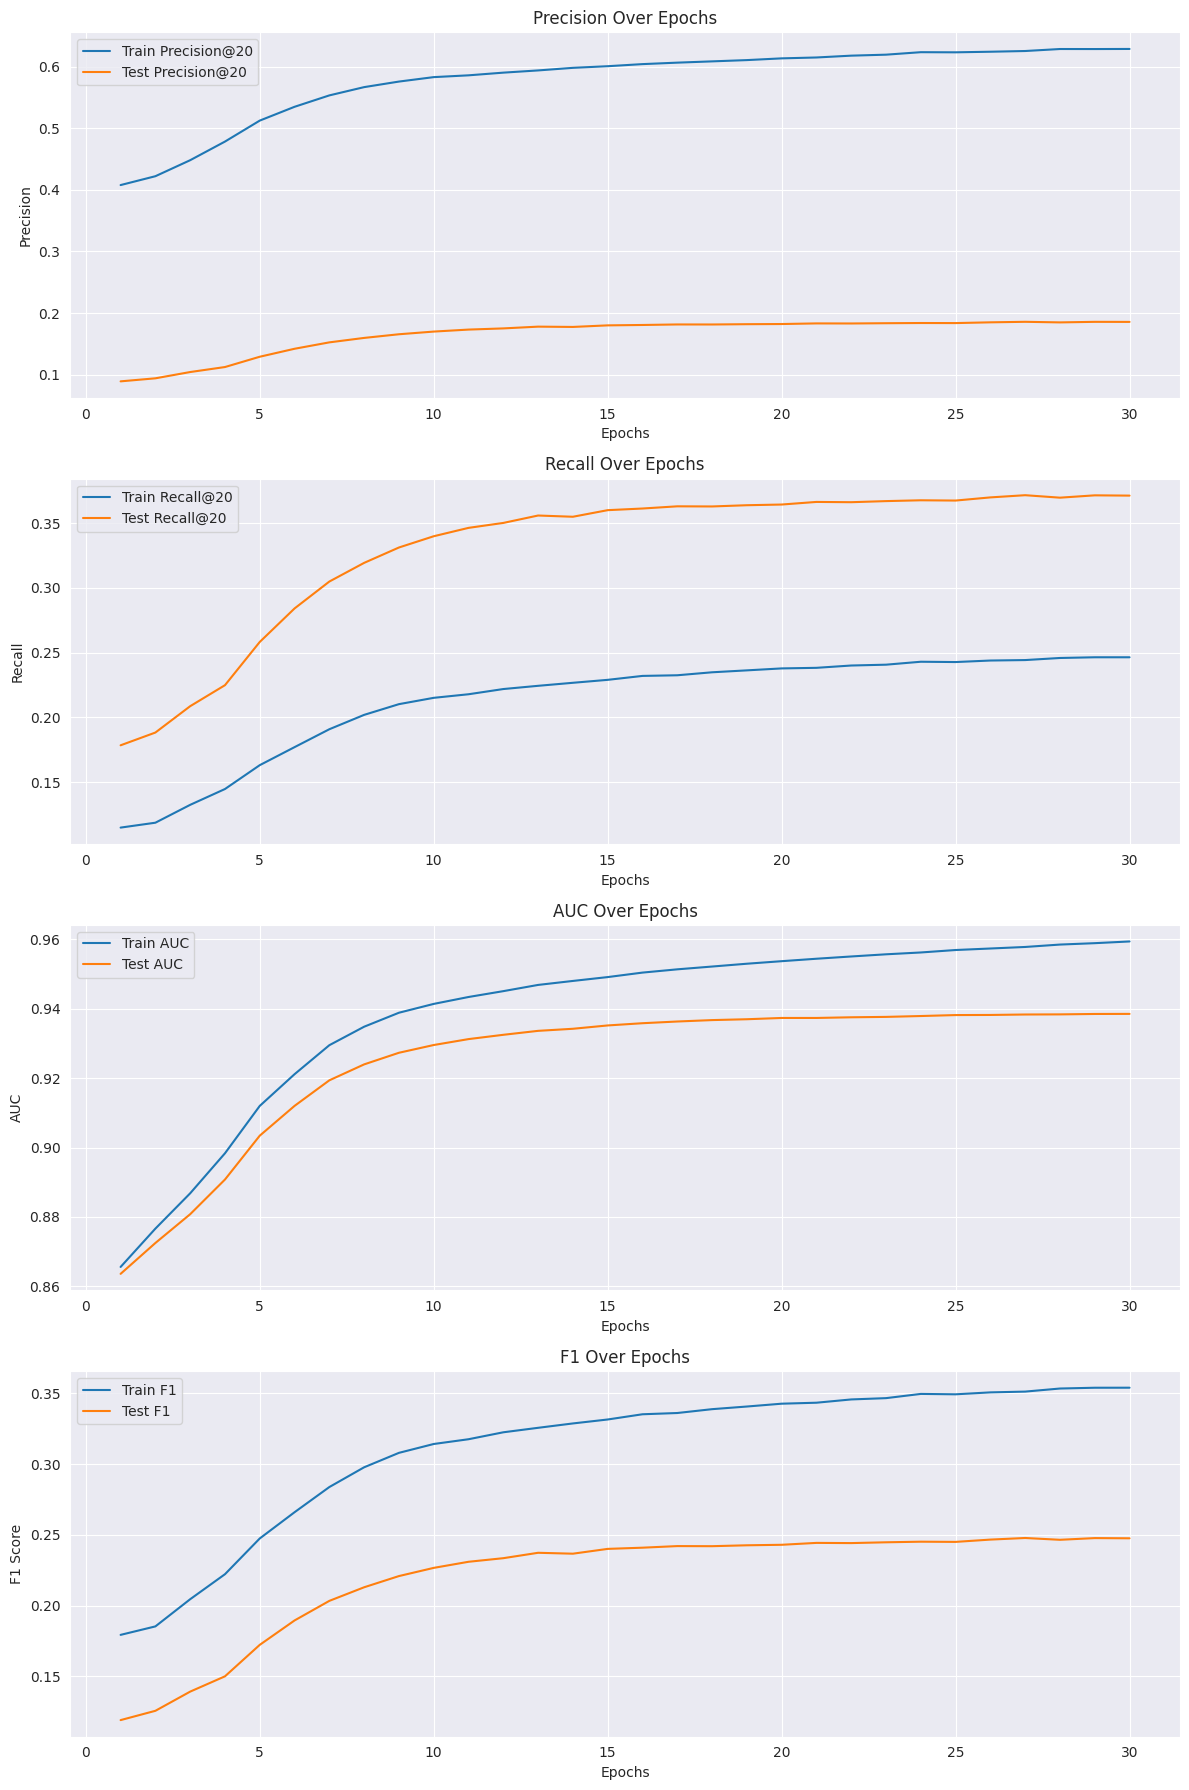

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))

plt.subplot(4, 1, 1)
plt.plot(epochs_range, train_precision_list, label=f"Train Precision@{K}")
plt.plot(epochs_range, test_precision_list, label=f"Test Precision@{K}")
plt.title("Precision Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(epochs_range, train_recall_list, label=f"Train Recall@{K}")
plt.plot(epochs_range, test_recall_list, label=f"Test Recall@{K}")
plt.title("Recall Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(epochs_range, train_auc_list, label="Train AUC")
plt.plot(epochs_range, test_auc_list, label="Test AUC")
plt.title("AUC Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(epochs_range, train_f1_list, label="Train F1")
plt.plot(epochs_range, test_f1_list, label="Test F1")
plt.title("F1 Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [106]:
# Make recommendations for a user on the test set
user_id = 1
n_items = test_data["item_id"].max()

# Generate item recommendations for the given user
scores = model.predict(
    user_id,
    np.arange(n_items),
    user_features=user_features,
    item_features=movie_features,
)

# Rank the items based on scores
top_items = np.argsort(-scores)

# Print top N recommendations
top_n = 5
print(f"Top {top_n} recommendations for user {user_id}:")
movie_data_with_genres.loc[top_items[:top_n]]

Top 5 recommendations for user 1:


,item_id,title,release_date,video_release_date,imdb_url,genre
285,286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,Drama
274,275,Sense and Sensibility (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Sense%20and%2...,Drama
284,285,Secrets & Lies (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Secrets%20&%2...,Drama
268,269,"Full Monty, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Full+Monty%2C...,Comedy
293,294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),Comedy


In [140]:
scores

array([ 1.1271946 , -3.1539361 , -0.99943626, ..., -1.9102482 ,
       -3.038394  , -2.429705  ], dtype=float32)